In [16]:
import polars as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sktime.distances import dtw_distance

In [17]:
def parse_datetime(dt_string):
    return datetime.datetime.strptime(dt_string, "%Y-%m-%d %H:%M:%S")

In [18]:
"""
curr_webget.csv	    Web browsing performance
unit_id	            Unique identifier for an individual unit
dtime	            Time test finished in local time
ddate           	Date test finished in local time
target          	URL to fetch
address         	IP address connected to to fetch content from initial URL
fetch_time	        Sum of time consumed to download Html content and then concurrently download all resources (Units: micorsecounds)
bytes_total	        Sum of HTML content size and all resources size (Units : Bytes)
bytes_sec	        Average speed of downloading HTML content and then concurrently downloading all resources (Units: bytes/sec)
objects	            Number of Resources (images, css etc) downloaded
threads	            Maximum number of concurrent threads allowed
requests        	Total number of HTTP requests made
connections	        Total number of TCP connections established
reused_connections	Number of TCP connections re-used
lookups	            Number of DNS lookups performed
request_total_time	Total duration of all requests summed together, if made sequentially
request_min_time	Shortest request duration
request_avg_time	Average request duration
request_max_time	Longest request duration
ttfb_total_time	    Total duration of the time-to-first-byte summed together, if made sequentially
ttfb_min_time	    Shortest time-to-first-byte duration
ttfb_avg_time	    Average time-to-first-byte duration
ttfb_max_time	    Longest time-to-first-byte duration
lookup_total_time	Total duration of all DNS lookups summed together, if made sequentially
lookup_min_time	    Shortest DNS lookup duration
lookup_avg_time	    Average DNS lookup duration
lookup_max_time	    Longest DNS lookup duration
successes	        Number of successes
failures	        Number of failures
"""
webget_df = pd.read_csv("validated-data-sept2022/curr_webget.csv")
units_df = pd.read_csv("validated-data-sept2022/unit-profile-sept2022.csv", infer_schema_length=10000)

webget_df.describe()

statistic,unit_id,dtime,ddate,target,address,fetch_time,bytes_total,bytes_sec,objects,threads,requests,connections,reused_connections,lookups,request_total_time,request_min_time,request_avg_time,request_max_time,ttfb_total,ttfb_min,ttfb_avg,ttfb_max,lookup_total_time,lookup_min_time,lookup_avg_time,lookup_max_time,successes,failures
str,f64,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4.327612e6,"""4327612""","""4327612""","""4327612""","""4327612""",4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6,4.327612e6
"""null_count""",0.0,"""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",3.4338e7,null,null,null,null,2.2859e6,2.0661e6,1.1489e6,19.957516,8.0,19.787458,12.432393,7.355064,3.481104,1.8263e7,115609.234235,696684.13436,1.4856e6,4.9567e6,159277.292556,326257.268254,574591.035329,253811.156258,60949.210609,74142.490398,101748.248337,1.0,0.0
"""std""",2.8041e7,null,null,null,null,3.1656e6,1.6833e6,1.0237e6,19.824713,0.0,19.737505,10.245468,10.857861,2.747289,3.3654e7,230594.956134,1.0111e6,2.4256e6,7.7581e6,160551.232564,462954.782726,879151.157296,1.7670e6,440834.54781,463903.742526,591265.725205,0.0,0.0
"""min""",447.0,"""2022-09-12 00:00:00""","""2022-09-12""","""http://edition.cnn.com/""","""1.1.1.6""",50000.0,51.0,15.0,1.0,8.0,1.0,1.0,0.0,1.0,1699.0,1699.0,1699.0,1699.0,1450.0,1450.0,1450.0,1450.0,-355559.0,-355559.0,-355559.0,-355559.0,1.0,0.0
"""25%""",3.898153e6,null,null,null,null,954696.0,220751.0,469677.0,3.0,8.0,3.0,3.0,0.0,1.0,1.058055e6,40456.0,280477.0,485395.0,718292.0,78235.0,155441.0,180289.0,26594.0,13551.0,16997.0,19424.0,1.0,0.0
"""50%""",3.5318429e7,null,null,null,null,1.594972e6,1.750606e6,817013.0,10.0,8.0,10.0,9.0,1.0,2.0,7.197212e6,68771.0,457380.0,929972.0,2.92845e6,136351.0,266945.0,388068.0,59683.0,21323.0,24826.0,28439.0,1.0,0.0
"""75%""",5.5518713e7,null,null,null,null,2.438486e6,2.81123e6,1.679305e6,31.0,8.0,31.0,24.0,8.0,5.0,1.9703949e7,138824.0,769936.0,1.467366e6,6.883532e6,198300.0,343850.0,591039.0,141364.0,30862.0,36548.0,46710.0,1.0,0.0
"""max""",8.2211365e7,"""2022-10-31 23:59:59""","""2022-10-31""","""http://www.msn.com/""","""99.86.5.87""",2.99997e7,4.721411e6,4.439553e6,200.0,8.0,200.0,40.0,182.0,11.0,1.6356e9,2.9809013e7,2.9809013e7,2.9809013e7,1.82700264e8,2.4523762e7,2.4523762e7,2.8816155e7,8.0266808e7,2.8905621e7,2.8905621e7,2.8905621e7,1.0,0.0


In [19]:
webget_df_ts = webget_df.join(
    units_df, left_on="unit_id", right_on="Unit ID", how="left"
)

webget_df_ts = webget_df_ts.with_columns(
    pd.col("dtime")
        .map_elements(lambda dt: parse_datetime(dt).timestamp())
        .alias("ts_start")
).with_columns(
    (pd.col("ts_start") - pd.col("timezone_offset") * 3600).alias("ts_start")  # replace 'offset_column' with actual name
).with_columns(
    (pd.col("ts_start") + pd.col("request_total_time") / 1000_000).alias("ts_end")
)
webget_df_ts

/var/folders/t7/vs_g77jx593d4x161y_zfvwc0000gn/T/ipykernel_61360/560623585.py:5: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  webget_df_ts = webget_df_ts.with_columns(


unit_id,dtime,ddate,target,address,fetch_time,bytes_total,bytes_sec,objects,threads,requests,connections,reused_connections,lookups,request_total_time,request_min_time,request_avg_time,request_max_time,ttfb_total,ttfb_min,ttfb_avg,ttfb_max,lookup_total_time,lookup_min_time,lookup_avg_time,lookup_max_time,successes,failures,ISP,Technology,State,Census,timezone_offset,timezone_offset_dst,Download,Upload,Whitebox Model,ts_start,ts_end
i64,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,i64,i64,f64,f64,str,f64,f64
41088977,"""2022-10-25 05:17:19""","""2022-10-25""","""http://www.google.com/policies…","""172.217.5.4""",502580,1349,2684,1,8,1,1,0,1,52759,52759,52759,52759,52358,52358,52358,52358,448874,448874,448874,448874,1,0,"""Frontier""","""DSL""","""OH""","""Midwest""",-5,-4,12.0,0.512,"""skwb8""",1.6667e9,1.6667e9
56315053,"""2022-10-30 05:58:37""","""2022-10-30""","""http://www.google.com/policies…","""172.217.5.4""",196295,1349,6872,1,8,1,1,0,1,134901,134901,134901,134901,133713,133713,133713,133713,60375,60375,60375,60375,1,0,"""CenturyLink""","""DSL""","""PA""","""Northeast""",-5,-4,7.0,0.512,"""skwb8""",1.6671e9,1.6671e9
40730241,"""2022-10-29 05:43:11""","""2022-10-29""","""http://www.google.com/policies…","""172.217.5.4""",127696,1349,10564,1,8,1,1,0,1,106345,106345,106345,106345,105779,105779,105779,105779,20325,20325,20325,20325,1,0,"""CenturyLink""","""DSL""","""KS""","""Midwest""",-6,-5,25.0,2.0,"""skwb8""",1.6670e9,1.6670e9
50156861,"""2022-10-24 19:53:26""","""2022-10-24""","""http://www.google.com/policies…","""172.217.5.4""",117890,1349,11442,1,8,1,1,0,1,113307,113307,113307,113307,108665,108665,108665,108665,3700,3700,3700,3700,1,0,"""CenturyLink""","""DSL""","""OH""","""Midwest""",-5,-4,1.5,0.512,"""skwb8""",1.6666e9,1.6666e9
3952881,"""2022-09-13 09:36:42""","""2022-09-13""","""http://www.google.com/policies…","""172.217.5.4""",100969,1349,13360,1,8,1,1,0,1,70110,70110,70110,70110,69795,69795,69795,69795,29762,29762,29762,29762,1,0,"""Mediacom""","""Cable""","""MO""","""Midwest""",-6,-5,400.0,30.0,"""skwb8""",1.6631e9,1.6631e9
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
80213805,"""2022-10-25 13:37:34""","""2022-10-25""","""http://www.ebay.com/""","""173.223.157.48""",2109750,1880074,891135,64,8,64,34,30,3,57559515,19213,899367,1507029,6901060,115754,202972,337089,50114,14697,16704,18288,1,0,"""Windstream""","""DSL""","""TX""","""South""",-6,-5,100.0,50.0,"""skwb8p""",1.6667e9,1.6667e9
56315045,"""2022-10-19 23:58:40""","""2022-10-19""","""http://www.ebay.com/""","""23.35.73.172""",2760557,1927049,698065,61,8,61,35,26,3,58402224,42219,957413,1768665,10734495,180938,306699,480722,102612,30147,34204,40988,1,0,"""CenturyLink""","""DSL""","""NE""","""Midwest""",-7,-6,60.0,5.0,"""skwb8""",1.6662e9,1.6662e9
25754881,"""2022-10-24 23:46:44""","""2022-10-24""","""http://www.ebay.com/""","""184.84.137.37""",2605230,1927160,739727,66,8,66,35,31,3,63745178,40455,965836,1631016,9992192,131783,285491,605208,51253,16256,17084,18008,1,0,"""Charter""","""Cable""","""FL""","""South""",-5,-4,400.0,20.0,"""skwb8""",1.6667e9,1.6667e9


In [20]:
start_time = webget_df_ts["ts_start"].min()
end_time = webget_df_ts["ts_end"].max()


start_time, end_time, end_time - start_time, (end_time - start_time) / 3600 / 6
n_days = 200

In [21]:
webget_df_ts.filter(webget_df_ts["unit_id"] == 447)["bytes_sec"].max()

1368691

In [22]:
def generate_timeseries(unit_id):
    w = [0.0] * n_days
    ts = [0.0] * n_days

    df = webget_df_ts.filter(webget_df_ts["unit_id"] == unit_id).sort("ts_start")
    for i in range(len(df)):
        curr = df[i]
        ts_start, ts_end = curr["ts_start"][0], curr["ts_end"][0]
        time1 = (ts_start - start_time) / 3600 / 6 ### 0.35 => 0 hour and .35 already passed
        time2 = (ts_end - start_time) / 3600 / 6 ### 1.2 => 1 hour and .2 already passed
        hour1 = int(time1)
        hour2 = int(time2)

        if hour1 >= n_days or hour2 >= n_days:
            continue

        if hour1 == hour2:
            weight1 = time2 - time1
            weight2 = 0.0
        else:
            weight1 = 1 - (time1 - hour1)
            weight2 = time2 - hour2

        speed = curr["bytes_sec"][0] / (1024 * 1024) # MB/sec
        relative_speed = speed / curr["Download"][0]

        w[hour1] += weight1
        w[hour2] += weight2

        if weight1 > 0.0:
            if w[hour1] > 0.0:
                ts[hour1] = ts[hour1] + (weight1 / w[hour1]) * (relative_speed - ts[hour1])
            else:
                ts[hour1] = relative_speed
        if weight2 > 0.0:
            if w[hour2] > 0.0:
                ts[hour2] = ts[hour2] + (weight2 / w[hour2]) * (relative_speed - ts[hour2])
            else:
                ts[hour2] = relative_speed

    return ts

In [23]:
KEY_CLASS = ["ISP", "Technology", "State"]
KEY_STATE = ["State"]
KEY_TECH = ["Technology", "State"]
KEY_ISP = ["ISP", "State"]

class_map = {}
for i, entry in enumerate(np.array(units_df.unique(KEY_CLASS)[*KEY_CLASS])):
    class_map[tuple(entry)] = i

state_map = {}
for i, entry in enumerate(np.array(units_df.unique(KEY_STATE)[*KEY_STATE])):
    state_map[tuple(entry)] = i

technology_map = {}
for i, entry in enumerate(np.array(units_df.unique(KEY_TECH)[*KEY_TECH])):
    technology_map[tuple(entry)] = i

isp_map = {}
for i, entry in enumerate(np.array(units_df.unique(KEY_ISP)[*KEY_ISP])):
    isp_map[tuple(entry)] = i

len(class_map), len(state_map), len(technology_map), len(isp_map)

(184, 47, 101, 177)

In [24]:
unit_ids = webget_df_ts["unit_id"].unique().sort()

ts = []
class_labels = []
state_labels = []
technology_labels = []
isp_labels = []

for i, uid in enumerate(unit_ids):
    ts.append(generate_timeseries(uid))
    class_label = class_map[tuple(*np.array(units_df.filter(units_df["Unit ID"] == uid)[*KEY_CLASS]))]
    state_label = state_map[tuple(*np.array(units_df.filter(units_df["Unit ID"] == uid)[*KEY_STATE]))]
    tech_label = technology_map[tuple(*np.array(units_df.filter(units_df["Unit ID"] == uid)[*KEY_TECH]))]
    isp_label = isp_map[tuple(*np.array(units_df.filter(units_df["Unit ID"] == uid)[*KEY_ISP]))]
    
    class_labels.append(class_label)
    state_labels.append(state_label)
    technology_labels.append(tech_label)
    isp_labels.append(isp_label)
    print(f"\r{i + 1}/{len(unit_ids)}", end="")
print()
# ts = np.array(ts)

2025/2025


In [25]:
from sklearn.metrics import confusion_matrix, mutual_info_score, rand_score

def purity_score(y_true, y_pred):
    contingency_matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def eval_clusters(y_pred, y_true):
    y_baseline = np.random.randint(np.min(y_true), np.max(y_true) + 1, len(y_true))
    print(f"normalized_mutual_info_score: {normalized_mutual_info_score(y_true, y_pred)} (baseline: {normalized_mutual_info_score(y_true, y_baseline)})")
    print(f"purity_score: {purity_score(y_true, y_pred)} (baseline: {purity_score(y_true, y_baseline)})")




print("STATE:::")

kmeans_state = KMeans(n_clusters=len(state_map), random_state=42).fit(ts)

eval_clusters(kmeans_state.labels_, state_labels)

###

print("\n\nSTATE-TECHNOLOGY:::")

kmeans_tech = KMeans(n_clusters=len(technology_map), random_state=42).fit(ts)

eval_clusters(kmeans_tech.labels_, technology_labels)

###

print("\n\nSTATE-ISP:::")

kmeans_isp = KMeans(n_clusters=len(isp_map), random_state=42).fit(ts)

eval_clusters(kmeans_isp.labels_, isp_labels)

###

print("\n\nSTATE-TECHNOLOGY-ISP:::")

kmeans_class = KMeans(n_clusters=len(class_map), random_state=42).fit(ts)

eval_clusters(kmeans_class.labels_, class_labels)

STATE:::
normalized_mutual_info_score: 0.1712938593249771 (baseline: 0.13342506674543458)
purity_score: 0.16691358024691358 (baseline: 0.12444444444444444)


STATE-TECHNOLOGY:::
normalized_mutual_info_score: 0.33380900323393736 (baseline: 0.30983415725311697)
purity_score: 0.19407407407407407 (baseline: 0.1259259259259259)


STATE-ISP:::
normalized_mutual_info_score: 0.39127534505072004 (baseline: 0.4382525987280679)
purity_score: 0.22271604938271605 (baseline: 0.15012345679012346)


STATE-TECHNOLOGY-ISP:::
normalized_mutual_info_score: 0.4050630829570333 (baseline: 0.45262017767732016)
purity_score: 0.22469135802469137 (baseline: 0.15555555555555556)


In [26]:
mds = MDS(n_components=2, dissimilarity="euclidean")
ts_mds = mds.fit_transform(ts)

<Axes: xlabel='x', ylabel='y'>

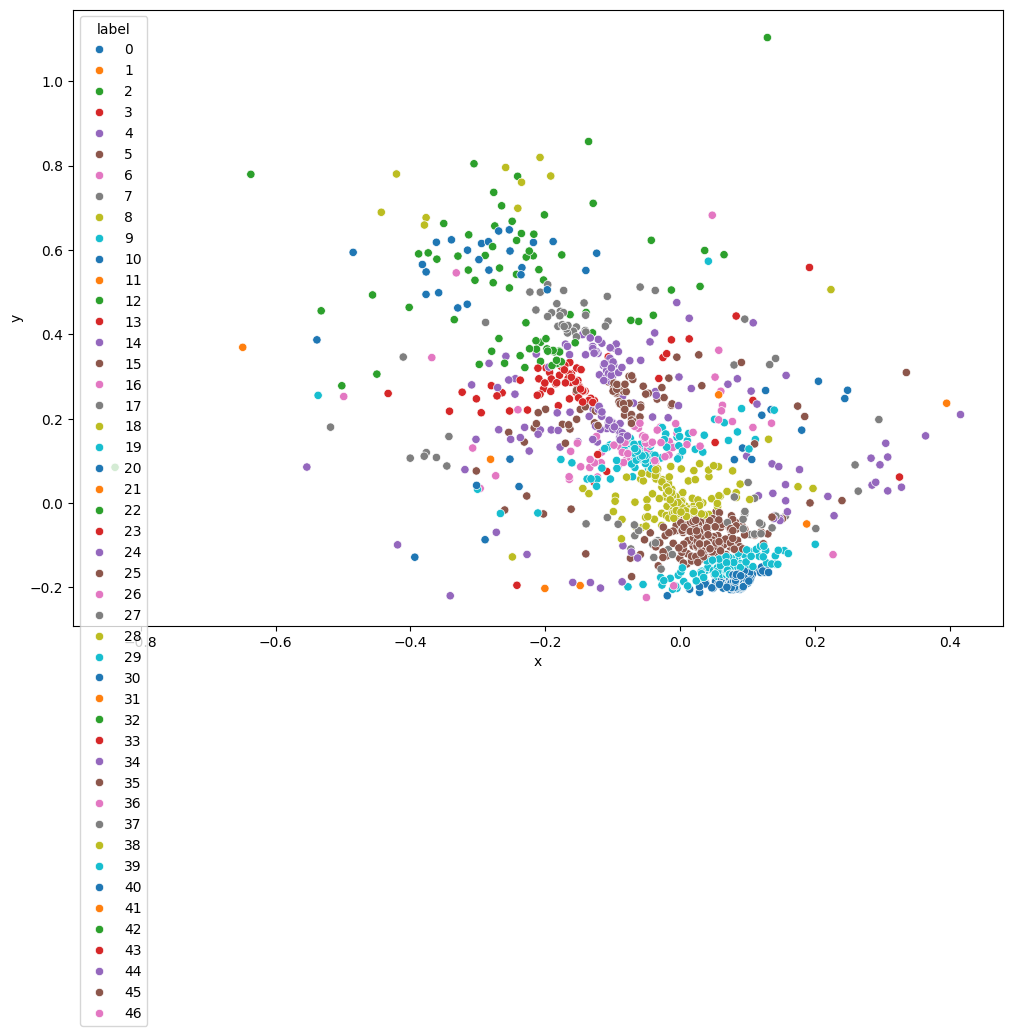

In [27]:
plt.figure(figsize=(12, 8))
import seaborn as sns
df_scatter = pd.DataFrame({
    "x": ts_mds[:,0],
    "y": ts_mds[:,1],
    "label": kmeans_state.labels_,
})
sns.scatterplot(data=df_scatter, x="x", y="y", hue="label", palette='tab10')

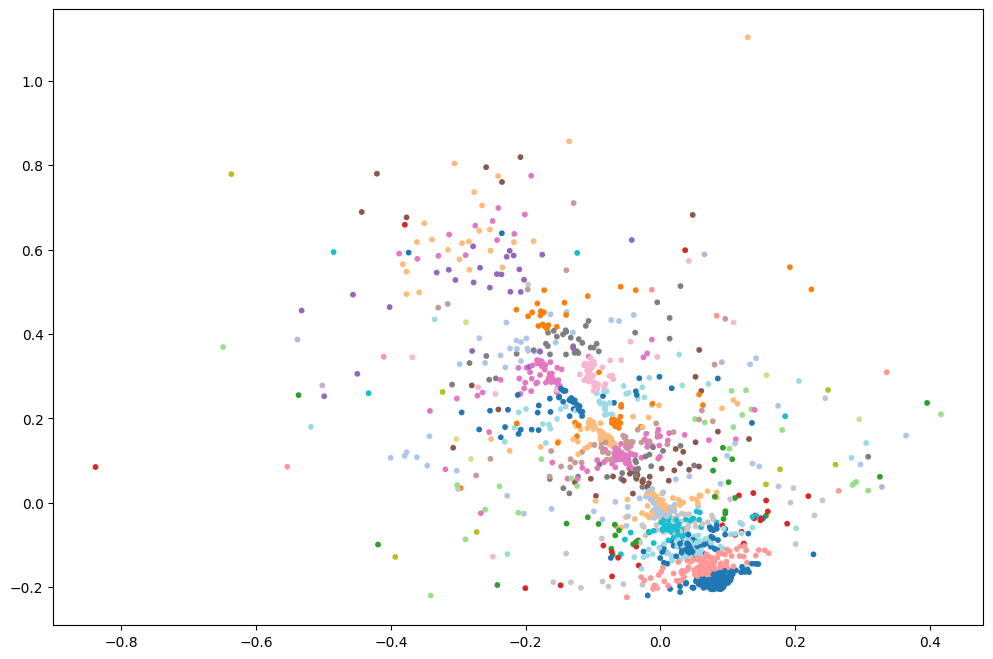

In [28]:
plt.figure(figsize=(12, 8))
plt.scatter(ts_mds[:,0], ts_mds[:,1], c=kmeans_tech.labels_, cmap="tab20", s=10)

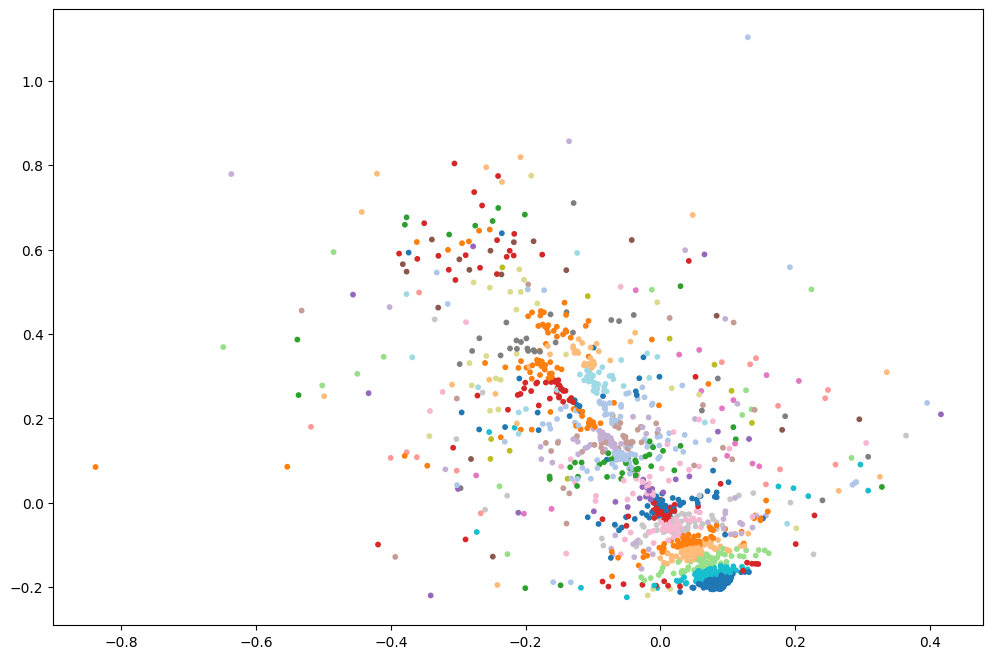

In [29]:
plt.figure(figsize=(12, 8))
plt.scatter(ts_mds[:,0], ts_mds[:,1], c=kmeans_isp.labels_, cmap="tab20", s=10)

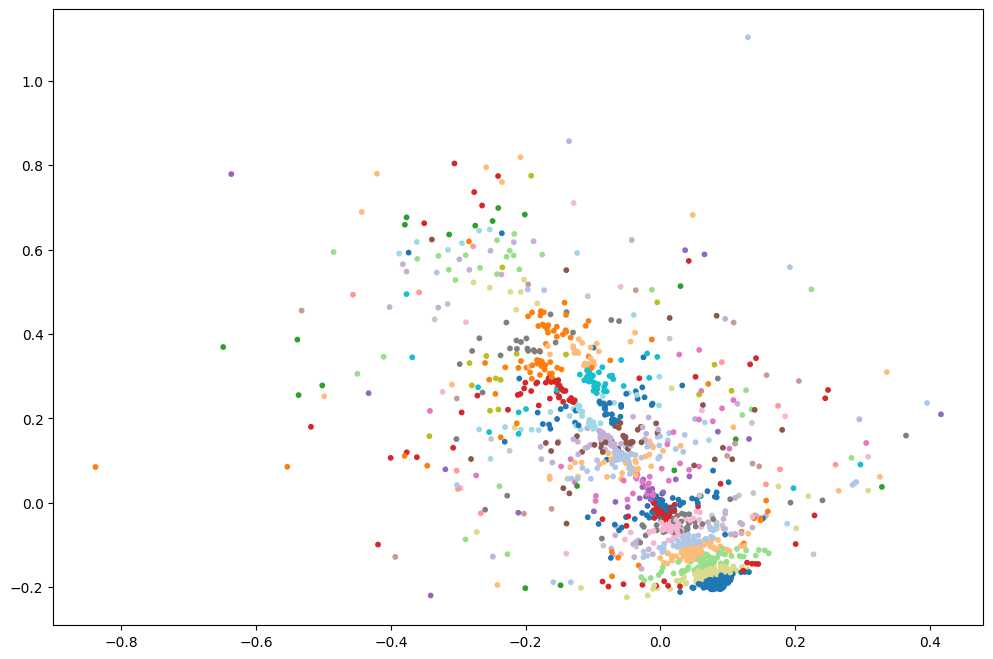

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(ts_mds[:,0], ts_mds[:,1], c=kmeans_class.labels_, cmap="tab20", s=10)